# 目的

学習した機械学習器の学習・予測データの予測に寄与した特徴量を可視化する

## 機械学習モデルの解釈
SHAPによって、入出力値から、出力に寄与した特徴量をSHAP値で表現できる。  
しかし、前処理でPCAを実施しているため、SHAPで出力される特徴量はPCAのままである。  
このままでは出力に寄与した遺伝子名（生の特徴量）がわからないため、PCAのloading（因子負荷量：主成分と元の特徴量を標準化した変数の相関係数）をSHAPの平均絶対値と内積をとってordinal score：順序スコアを定義する。


In [1]:
# 基本的なライブラリ
import warnings
from tqdm import tqdm

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# パイプライン（imblearn）
from imblearn.pipeline import Pipeline
from imblearn import FunctionSampler

from sksurv.ensemble import (
    ComponentwiseGradientBoostingSurvivalAnalysis,
    GradientBoostingSurvivalAnalysis,
    RandomSurvivalForest,
    ExtraSurvivalTrees,
)
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.tree import SurvivalTree

# XAI
import shap

# config python file
import config
import functions

SEED = config.SEED
TARGET_NAME = ["RFS_STATUS", "RFS_MONTHS"]
functions.fix_seed(SEED)


df_recurrenced = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_recurrenced4numeric.pkl"
)

# SHAP

In [2]:
def save_shap_instances(
    shap_explainer: callable,
    shap_values: callable,
    save_file_path: str = ".",
):
    # fit後pipelineの保存
    functions.make_dir(save_file_path)
    functions.dill_dump(shap_explainer, "{0}/shap_explainer.pkl".format(save_file_path))
    functions.dill_dump(shap_values, "{0}/shap_values.pkl".format(save_file_path))

In [3]:
def explain_model(
    input_data_path: str = None,
    input_pipe_path: str = None,
    output_file_path: str = None,
):
    # 学習データ・学習済みパイプラインの読み込み
    try:
        _X = pd.read_pickle("{0}/X.pkl".format(input_data_path))
        _y = pd.read_pickle("{0}/y.pkl".format(input_data_path)).to_records(index=False)
        _model_pipeline = functions.pickle_load(
            "{0}/model_pipeline.pkl".format(input_pipe_path)
        )
        _estimator = _model_pipeline[-1]
    except:
        print("preprocess or pipeline pkl file dose not exist")
        return

    # load JS visualization code to notebook
    shap.initjs()

    # explain the model's predictions using SHAP values
    explainer = shap.explainers.Permutation(
        _estimator.predict, _X, max_evals="auto", seed=config.SEED
    )
    """
    explainer = shap.Explainer(
        _estimator.predict,
        _X,
        seed=config.SEED,
    )"""
    shap_values = explainer(_X)
    # shap.plots.beeswarm(shap_values)

    if output_file_path:
        save_shap_instances(
            shap_explainer=explainer,
            shap_values=shap_values,
            save_file_path=output_file_path,
        )

## 全体での実行

In [4]:
# 層別化する特徴量
def exec_shap(model_order_dict: dict()):
    drop_columns = [
        "CLAUDIN_SUBTYPE",
        "THREEGENE",
    ]

    print(".........." * 10)
    print("model_order_dict name: ", model_order_dict["model_name"])

    subgroup_path = "./{0}/{1}/{2}".format(
        model_order_dict["subgroup_column"],
        model_order_dict["subgroup"],
        model_order_dict["preprocess_name"],
    )
    input_data_path = "./{0}/{1}/{2}".format(
        config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
        subgroup_path,
        "test_set/test",
    )
    input_pipe_path = "./{0}/{1}/{2}/{3}".format(
        config.INTERIM_MODELS_RECURRENCE_DIR,
        subgroup_path,
        model_order_dict["model_name"],
        "test_set",
    )
    output_file_path = "./{0}/{1}/{2}/{3}".format(
        config.INTERIM_EXPLAIN_RECURRENCE_DIR,
        subgroup_path,
        model_order_dict["model_name"],
        "test_set",
    )
    print("input data path: ", input_data_path)
    print("input pipe path: ", input_pipe_path)
    print("output file path: ", output_file_path)
    explain_model(
        input_data_path=input_data_path,
        input_pipe_path=input_pipe_path,
        output_file_path=output_file_path,
    )

# ランキングの作成

## shap値の取得+pcaを利用した計算

In [22]:
def calc_score(
    model_order_dict: dict(),
) -> pd.DataFrame():

    subgroup_path = "./{0}/{1}/{2}".format(
        model_order_dict["subgroup_column"],
        model_order_dict["subgroup"],
        model_order_dict["preprocess_name"],
    )

    # load shap values
    pkl_path = "./{0}/{1}/{2}/{3}".format(
        config.INTERIM_EXPLAIN_RECURRENCE_DIR,
        subgroup_path,
        model_order_dict["model_name"],
        "/test_set",
    )
    try:
        sv = functions.dill_load(pkl_path + "/shap_values.pkl")
    except:
        exec_shap(model_order_dict)
        sv = functions.dill_load(pkl_path + "/shap_values.pkl")

    shap.plots.beeswarm(sv)
    # beeswarm plotに準じたDataFrameの作成
    df_shap = pd.DataFrame(
        sv.abs.mean(0).values, index=sv.feature_names, columns=["shap abs means"]
    )

    # load preprocess pipeline
    pkl_path = "./{0}/{1}/{2}".format(
        config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
        subgroup_path,
        "test_set/test",
    )
    preprocess_pipeline = functions.pickle_load(pkl_path + "/preprocess_pipeline.pkl")
    pca = preprocess_pipeline[-1]

    # 主成分負荷量（loading）の計算
    loadings = pd.DataFrame(
        pca.components_ * np.c_[np.sqrt(pca.explained_variance_)],
        index=pca.get_feature_names_out(),
        columns=pca.feature_names_in_,
    )

    # shap値の絶対値平均値とloadingの絶対値の積に基づく順序ランキング作成
    scores = pd.DataFrame(
        np.dot(df_shap.T, abs(loadings)), index=["score"], columns=loadings.columns
    ).T
    ranking = scores.sort_values(by="score", ascending=False)
    ranking = ranking.reset_index().rename(columns={"index": "gene name"})
    return ranking

## 予測で最も性能の高かったパターンでのスコア算出

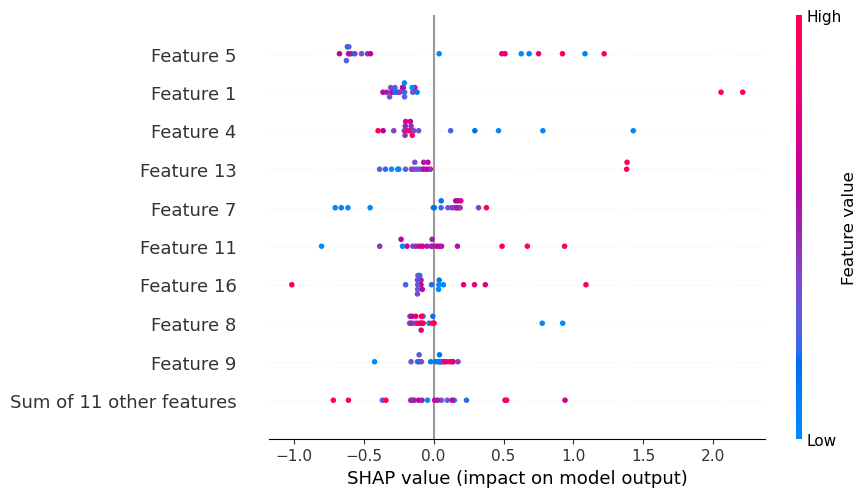

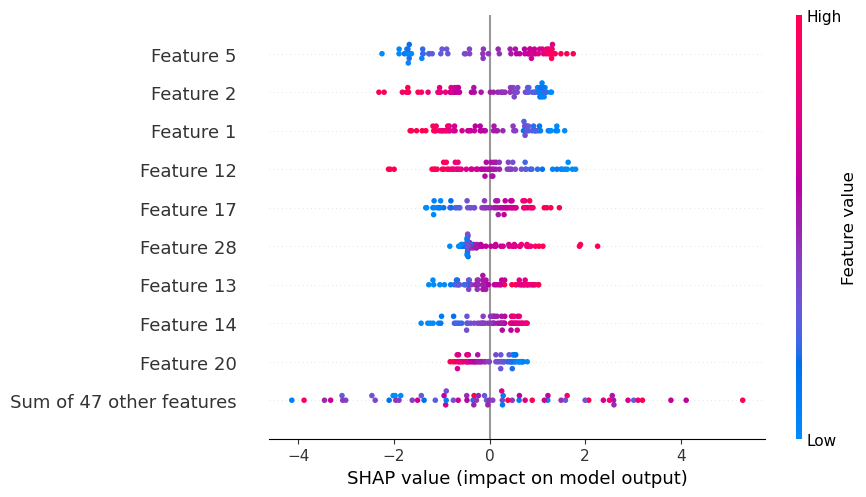

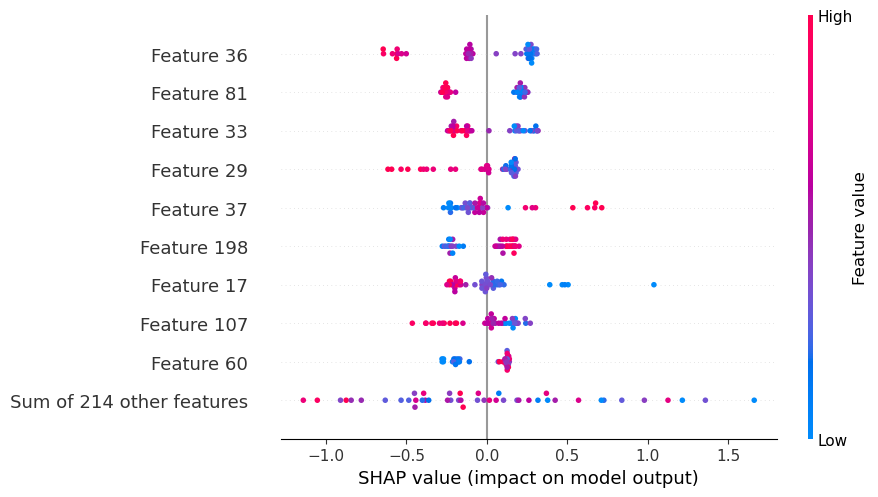

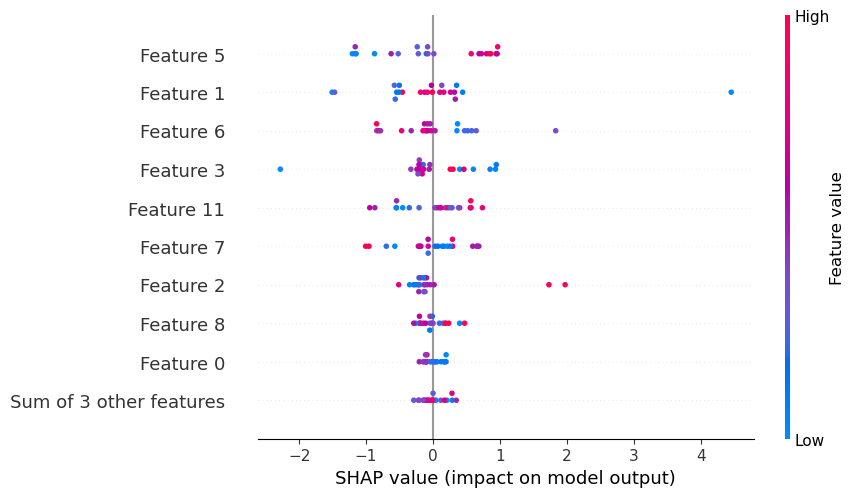

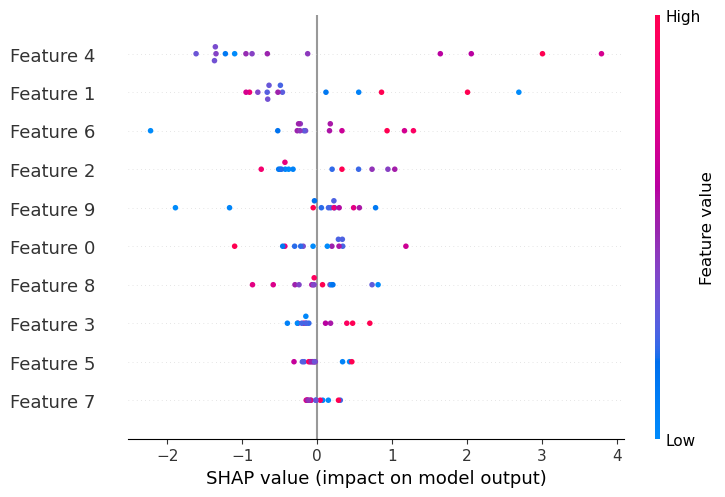

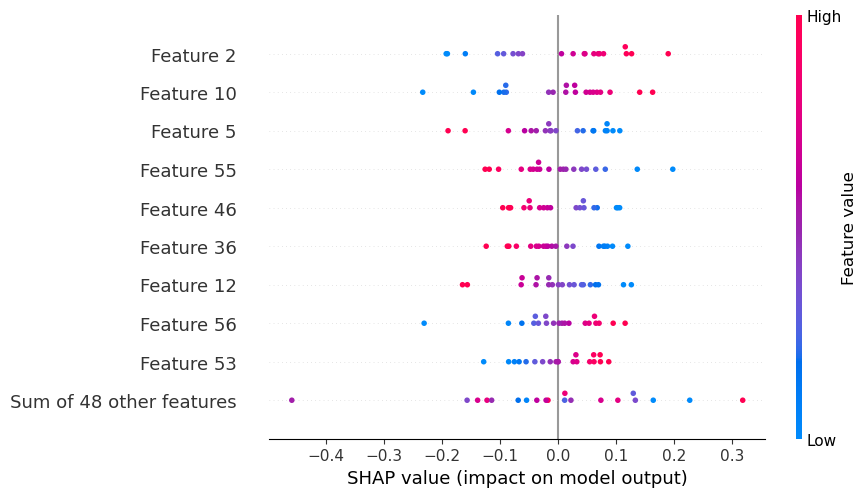

In [23]:
# 修士論文
model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca41",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "claudin-low",
}
rank_claudinlow = calc_score(
    model_order_dict,
)


model_order_dict = {
    "model_name": ExtraSurvivalTrees().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca43",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "LumA",
}
rank_LumA = calc_score(model_order_dict)


model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca77",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "LumB",
}
rank_LumB = calc_score(model_order_dict)


model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca31",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Her2",
}
rank_Her2 = calc_score(model_order_dict)


model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca30",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Normal",
}
rank_Normal = calc_score(model_order_dict)


model_order_dict = {
    "model_name": ComponentwiseGradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca58",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Basal",
}
rank_Basal = calc_score(model_order_dict)

In [15]:
rank_claudinlow = rank_claudinlow.rename(
    columns={"gene name": "gene_claudin-low", "score": "score_claudin-low"}
)
rank_LumA = rank_LumA.rename(columns={"gene name": "gene_LumA", "score": "score_LumA"})
rank_LumB = rank_LumB.rename(columns={"gene name": "gene_LumB", "score": "score_LumB"})
rank_Her2 = rank_Her2.rename(columns={"gene name": "gene_Her2", "score": "score_Her2"})
rank_Basal = rank_Basal.rename(columns={"gene name": "gene_Basal", "score": "Basal"})
rank_Normal = rank_Normal.rename(
    columns={"gene name": "gene_Normal", "score": "score_Normal"}
)

df_rank = rank_claudinlow.copy()
df_rank = pd.merge(df_rank, rank_LumA, right_index=True, left_index=True)
df_rank = pd.merge(df_rank, rank_LumB, right_index=True, left_index=True)
df_rank = pd.merge(df_rank, rank_Her2, right_index=True, left_index=True)
df_rank = pd.merge(df_rank, rank_Normal, right_index=True, left_index=True)
df_rank = pd.merge(df_rank, rank_Basal, right_index=True, left_index=True)
# 一時的な保存
df_rank.to_csv("./explain_score.csv")
df_rank

,gene_claudin-low,score_claudin-low,gene_LumA,score_LumA,gene_LumB,score_LumB,gene_Her2,score_Her2,gene_Normal,score_Normal,gene_Basal,Basal
0,FAM98A,0.815218,KIF11,1.984594,CRYAB,0.398995,PRKCB,1.079602,ITGAX,1.600685,TTYH3,0.165710
1,WSB2,0.811024,ECT2,1.980717,ATOX1,0.394615,ITK,1.077976,FYN,1.582082,ANXA2P1,0.157219
2,YME1L1,0.805382,HMGB2,1.950213,MRAP,0.391781,IL23A,1.077428,FERMT3,1.577731,GCFC,0.155820
3,SON,0.804068,NEK2,1.943518,ZNF428,0.390918,PYHIN1,1.065910,ADA,1.563425,RPLP1,0.155291
4,SLC38A2,0.802511,PTTG3,1.942737,FHL1,0.390806,P2RY8,1.059498,APBB1IP,1.562869,FAM60A,0.155218
...,...,...,...,...,...,...,...,...,...,...,...,...
24363,BQ028095,0.097377,C13orf26,0.339557,BI770211,0.143752,SST,0.091662,AK093454,0.133731,SLC7A14,0.048426
24364,POU3F3,0.095030,LOC644662,0.337129,DA282036,0.143380,AA586561,0.090698,AB076958,0.131752,STON1,0.047252
24365,CSN2,0.094147,AI015182,0.332861,AW515292,0.142804,GAGE12B,0.075788,OR51B2,0.123224,B3GAT3,0.047103
24366,LOC100130673,0.092046,LOC728724,0.315551,TNKS2,0.142406,MYL10,0.069762,POU5F1B,0.093532,SLC18A3,0.047071


# 晩期再発者のみの調査

In [16]:
# 層別化する特徴量
def exec_shap4late_recurrences(model_order_dict: dict()):
    drop_columns = [
        "CLAUDIN_SUBTYPE",
        "THREEGENE",
    ]

    print(".........." * 10)
    print("model_order_dict name: ", model_order_dict["model_name"])

    subgroup_path = "./{0}/{1}/{2}".format(
        model_order_dict["subgroup_column"],
        model_order_dict["subgroup"],
        model_order_dict["preprocess_name"],
    )
    input_data_path = "./{0}/{1}/{2}".format(
        config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
        subgroup_path,
        "test_set/late_recurrences",
    )
    input_pipe_path = "./{0}/{1}/{2}/{3}".format(
        config.INTERIM_MODELS_RECURRENCE_DIR,
        subgroup_path,
        model_order_dict["model_name"],
        "test_set",
    )
    output_file_path = "./{0}/{1}/{2}/{3}".format(
        config.INTERIM_EXPLAIN_RECURRENCE_DIR,
        subgroup_path,
        model_order_dict["model_name"],
        "test_set/late_recurrences",
    )
    print("input data path: ", input_data_path)
    print("input pipe path: ", input_pipe_path)
    print("output file path", output_file_path)
    explain_model(
        input_data_path=input_data_path,
        input_pipe_path=input_pipe_path,
        output_file_path=output_file_path,
    )

In [33]:
# shap_valueをもとにプロット・保存を実施する関数
def plot_sv(sv):
    plt.figure(figsize=(6, 6))
    shap.plots.beeswarm(sv, show=False)
    plt.title(model_order_dict["subgroup"])
    plt.tight_layout()
    plt.savefig("./shap_{0}.png".format(model_order_dict["subgroup"]))


# 晩期再発者向けに定義した順序スコアを計算するための関数
def calc_score4late_recurrences(
    model_order_dict: dict(),
) -> pd.DataFrame():

    subgroup_path = "./{0}/{1}/{2}".format(
        model_order_dict["subgroup_column"],
        model_order_dict["subgroup"],
        model_order_dict["preprocess_name"],
    )

    # load shap values
    pkl_path = "./{0}/{1}/{2}/{3}".format(
        config.INTERIM_EXPLAIN_RECURRENCE_DIR,
        subgroup_path,
        model_order_dict["model_name"],
        "test_set/late_recurrences",
    )
    try:
        sv = functions.dill_load(pkl_path + "/shap_values.pkl")
    except:
        exec_shap4late_recurrences(model_order_dict)
        sv = functions.dill_load(pkl_path + "/shap_values.pkl")

    plot_sv(sv)

    # beeswarm plotに準じたDataFrameの作成
    df_shap = pd.DataFrame(
        sv.abs.mean(0).values, index=sv.feature_names, columns=["shap abs means"]
    )

    # load preprocess pipeline
    pkl_path = "./{0}/{1}/{2}".format(
        config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
        subgroup_path,
        "test_set/test",
    )
    preprocess_pipeline = functions.pickle_load(pkl_path + "/preprocess_pipeline.pkl")
    pca = preprocess_pipeline[-1]

    # 主成分負荷量（loading）の計算
    loadings = pd.DataFrame(
        pca.components_ * np.c_[np.sqrt(pca.explained_variance_)],
        index=pca.get_feature_names_out(),
        columns=pca.feature_names_in_,
    )

    # shap値の絶対値平均値とloadingの絶対値の積に基づく順序ランキング作成
    scores = pd.DataFrame(
        np.dot(df_shap.T, abs(loadings)), index=["score"], columns=loadings.columns
    ).T
    ranking = scores.sort_values(by="score", ascending=False)
    ranking = ranking.reset_index().rename(columns={"index": "gene name"})
    return ranking

....................................................................................................
model_order_dict name:  RandomSurvivalForest
input data path:  ./../data/interim/PREPROCESSED/RECURRENCE/./CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca92/test_set/late_recurrences
input pipe path:  ./../data/interim/MODELS/RECURRENCE/./CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca92/RandomSurvivalForest/test_set
output file path ./../data/interim/EXPLAIN/RECURRENCE/./CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca92/RandomSurvivalForest/test_set/late_recurrences


Permutation explainer: 23it [02:00,  5.72s/it]                                                                          


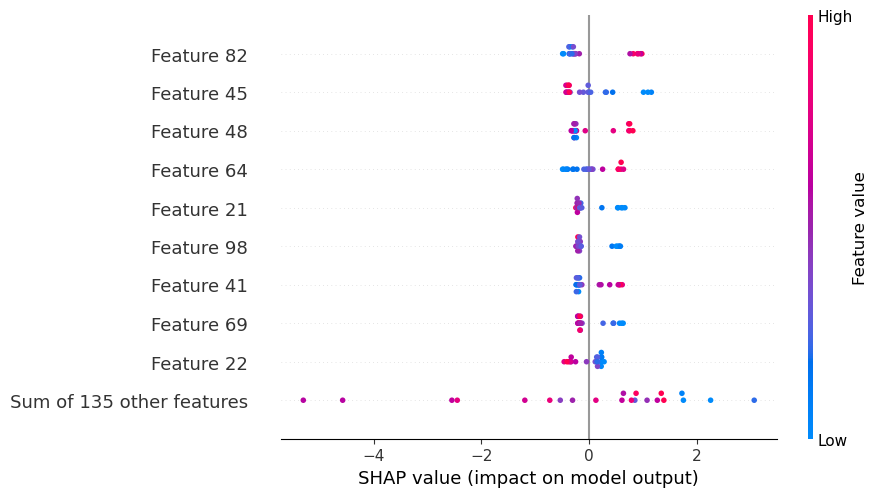

....................................................................................................
model_order_dict name:  RandomSurvivalForest
input data path:  ./../data/interim/PREPROCESSED/RECURRENCE/./CLAUDIN_SUBTYPE/LumA/preprocess4numeric_pca94/test_set/late_recurrences
input pipe path:  ./../data/interim/MODELS/RECURRENCE/./CLAUDIN_SUBTYPE/LumA/preprocess4numeric_pca94/RandomSurvivalForest/test_set
output file path ./../data/interim/EXPLAIN/RECURRENCE/./CLAUDIN_SUBTYPE/LumA/preprocess4numeric_pca94/RandomSurvivalForest/test_set/late_recurrences


Permutation explainer: 120it [10:55:54, 330.71s/it]                                                                     


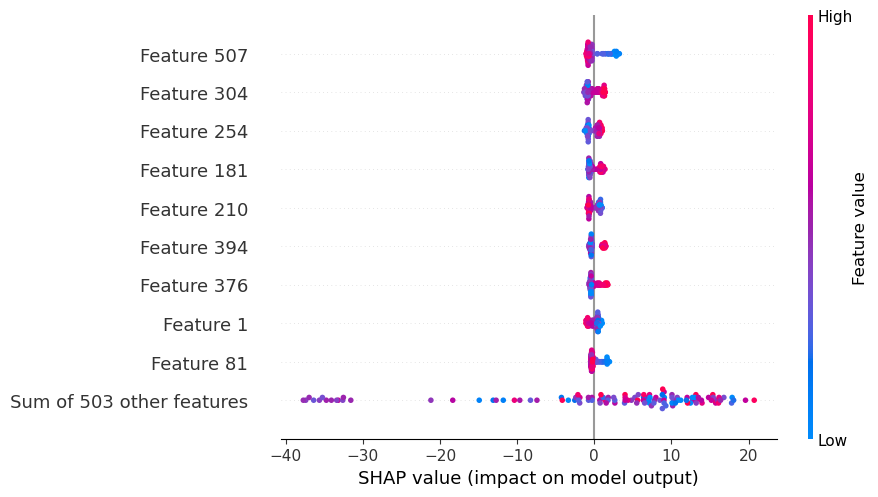

....................................................................................................
model_order_dict name:  GradientBoostingSurvivalAnalysis
input data path:  ./../data/interim/PREPROCESSED/RECURRENCE/./CLAUDIN_SUBTYPE/LumB/preprocess4numeric_pca82/test_set/late_recurrences
input pipe path:  ./../data/interim/MODELS/RECURRENCE/./CLAUDIN_SUBTYPE/LumB/preprocess4numeric_pca82/GradientBoostingSurvivalAnalysis/test_set
output file path ./../data/interim/EXPLAIN/RECURRENCE/./CLAUDIN_SUBTYPE/LumB/preprocess4numeric_pca82/GradientBoostingSurvivalAnalysis/test_set/late_recurrences


Permutation explainer: 88it [10:20,  7.22s/it]                                                                          


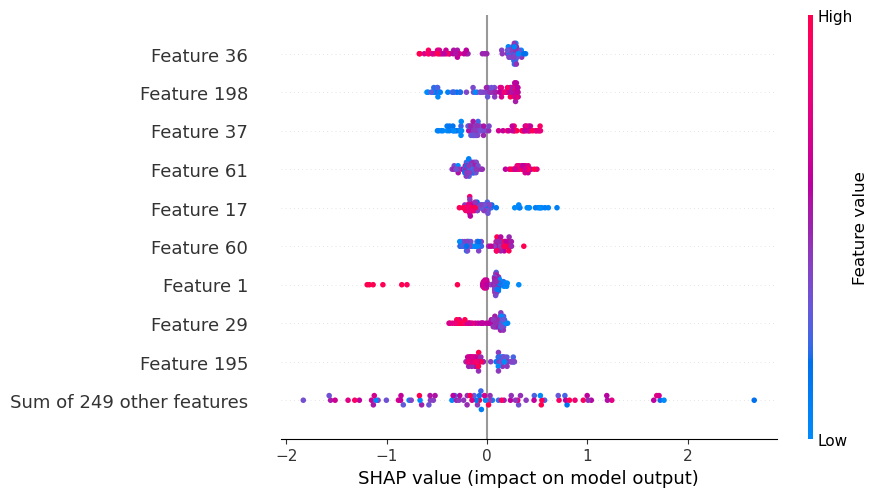

....................................................................................................
model_order_dict name:  GradientBoostingSurvivalAnalysis
input data path:  ./../data/interim/PREPROCESSED/RECURRENCE/./CLAUDIN_SUBTYPE/Her2/preprocess4numeric_pca95/test_set/late_recurrences
input pipe path:  ./../data/interim/MODELS/RECURRENCE/./CLAUDIN_SUBTYPE/Her2/preprocess4numeric_pca95/GradientBoostingSurvivalAnalysis/test_set
output file path ./../data/interim/EXPLAIN/RECURRENCE/./CLAUDIN_SUBTYPE/Her2/preprocess4numeric_pca95/GradientBoostingSurvivalAnalysis/test_set/late_recurrences


Permutation explainer: 30it [00:19,  1.29s/it]                                                                          


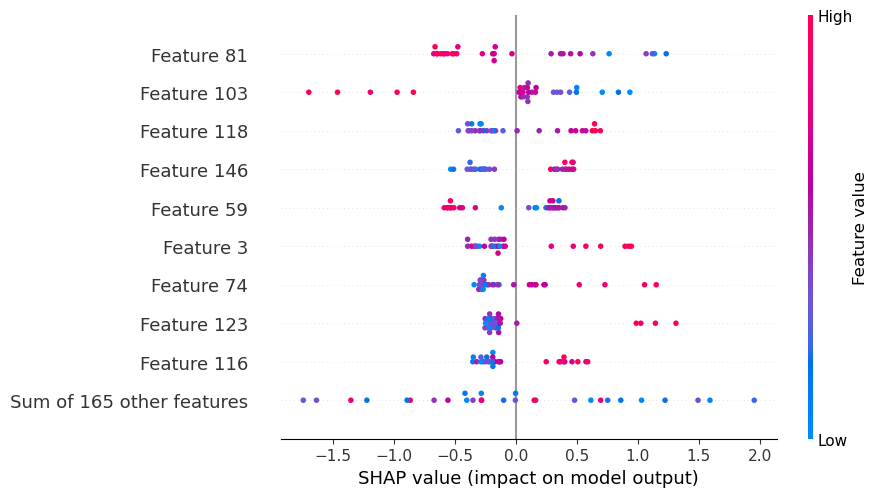

....................................................................................................
model_order_dict name:  RandomSurvivalForest
input data path:  ./../data/interim/PREPROCESSED/RECURRENCE/./CLAUDIN_SUBTYPE/Normal/preprocess4numeric_pca88/test_set/late_recurrences
input pipe path:  ./../data/interim/MODELS/RECURRENCE/./CLAUDIN_SUBTYPE/Normal/preprocess4numeric_pca88/RandomSurvivalForest/test_set
output file path ./../data/interim/EXPLAIN/RECURRENCE/./CLAUDIN_SUBTYPE/Normal/preprocess4numeric_pca88/RandomSurvivalForest/test_set/late_recurrences


Permutation explainer: 28it [01:57,  4.68s/it]                                                                          


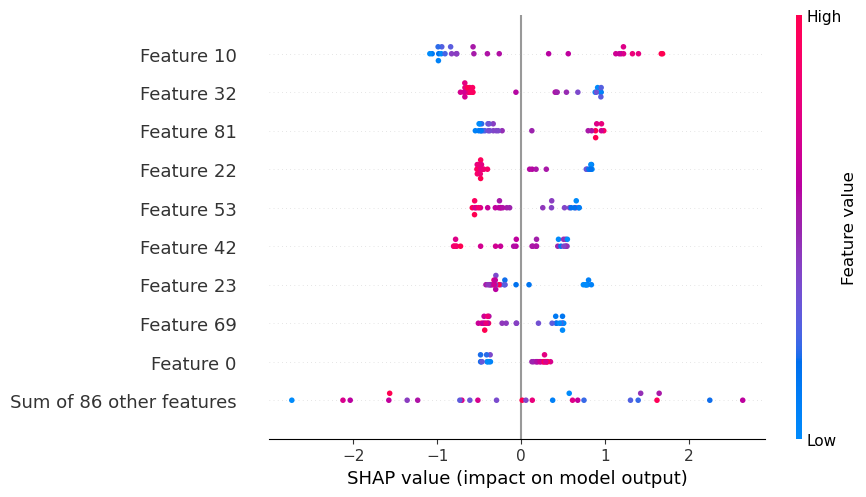

....................................................................................................
model_order_dict name:  ExtraSurvivalTrees
input data path:  ./../data/interim/PREPROCESSED/RECURRENCE/./CLAUDIN_SUBTYPE/Basal/preprocess4numeric_pca83/test_set/late_recurrences
input pipe path:  ./../data/interim/MODELS/RECURRENCE/./CLAUDIN_SUBTYPE/Basal/preprocess4numeric_pca83/ExtraSurvivalTrees/test_set
output file path ./../data/interim/EXPLAIN/RECURRENCE/./CLAUDIN_SUBTYPE/Basal/preprocess4numeric_pca83/ExtraSurvivalTrees/test_set/late_recurrences


Permutation explainer: 9it [00:27,  4.62s/it]                                                                           


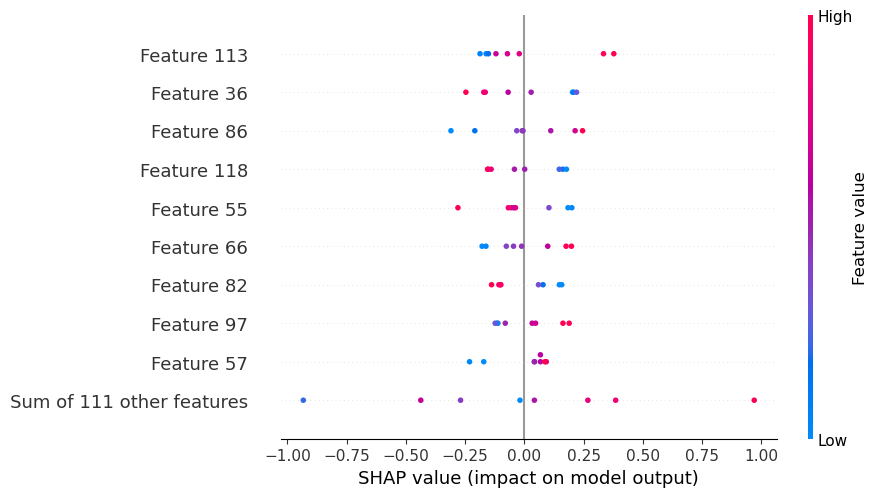

In [35]:
# AROB
model_order_dict = {
    "model_name": RandomSurvivalForest().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca92",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "claudin-low",
}
rank_claudinlow_late = calc_score4late_recurrences(
    model_order_dict,
)


model_order_dict = {
    "model_name": RandomSurvivalForest().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca94",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "LumA",
}
rank_LumA_late = calc_score4late_recurrences(model_order_dict)


model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca82",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "LumB",
}
rank_LumB_late = calc_score4late_recurrences(model_order_dict)


model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca95",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Her2",
}
rank_Her2_late = calc_score4late_recurrences(model_order_dict)


model_order_dict = {
    "model_name": RandomSurvivalForest().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca88",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Normal",
}
rank_Normal_late = calc_score4late_recurrences(model_order_dict)


model_order_dict = {
    "model_name": ExtraSurvivalTrees().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca83",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Basal",
}
rank_Basal_late = calc_score4late_recurrences(model_order_dict)

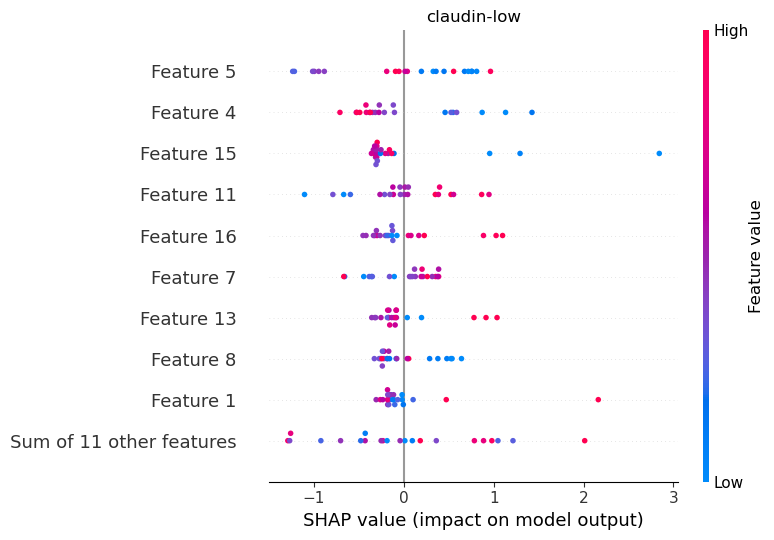

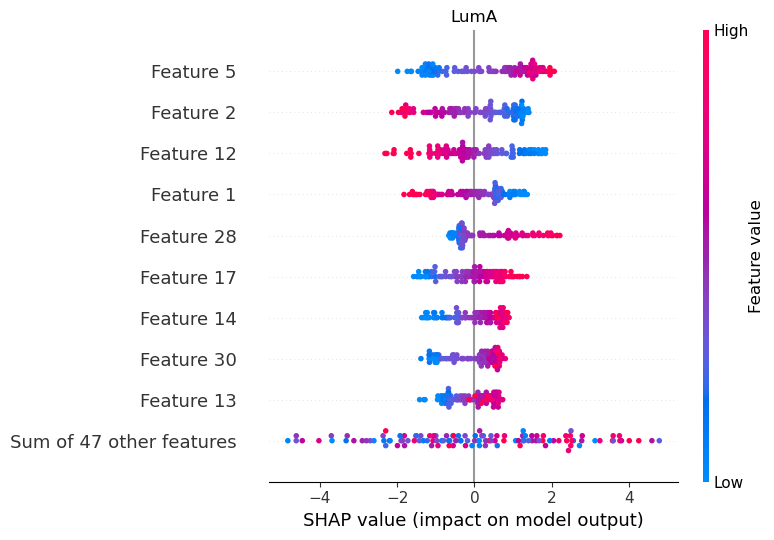

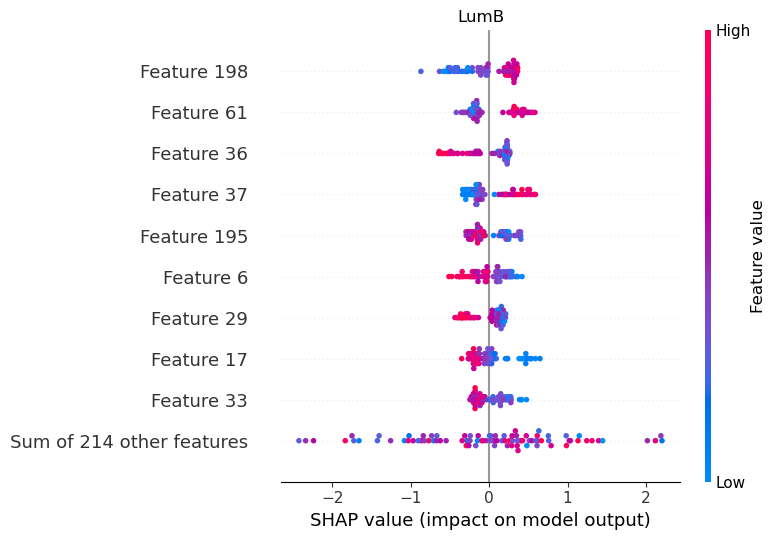

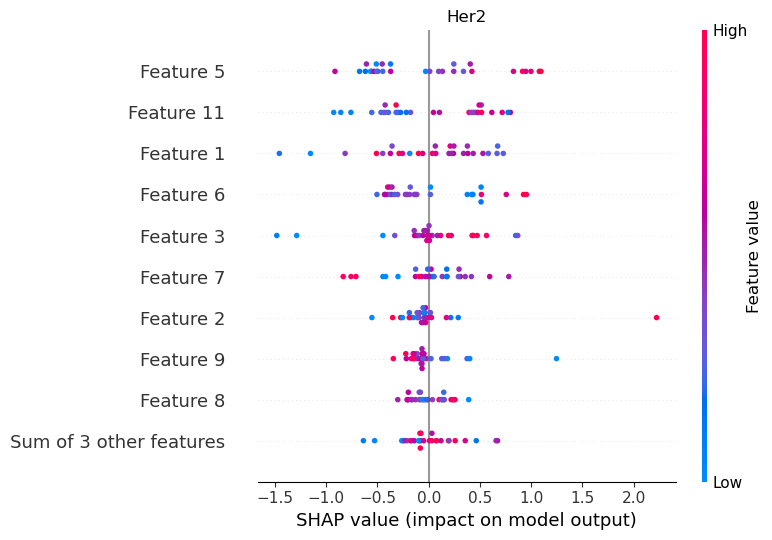

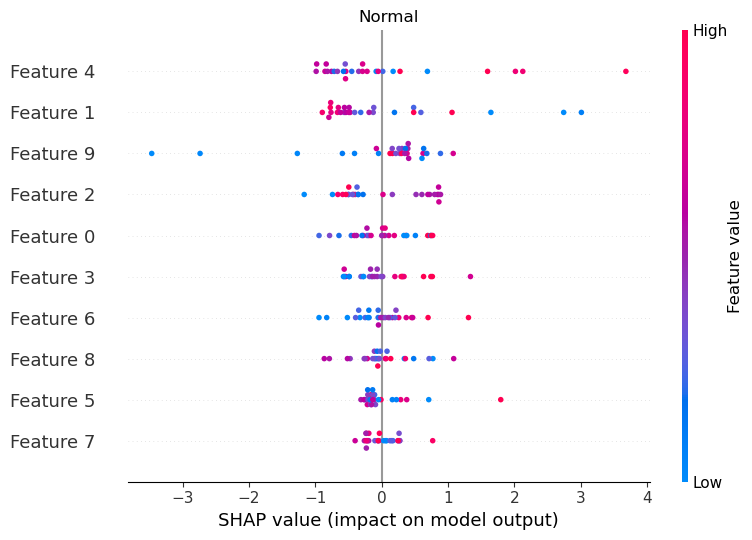

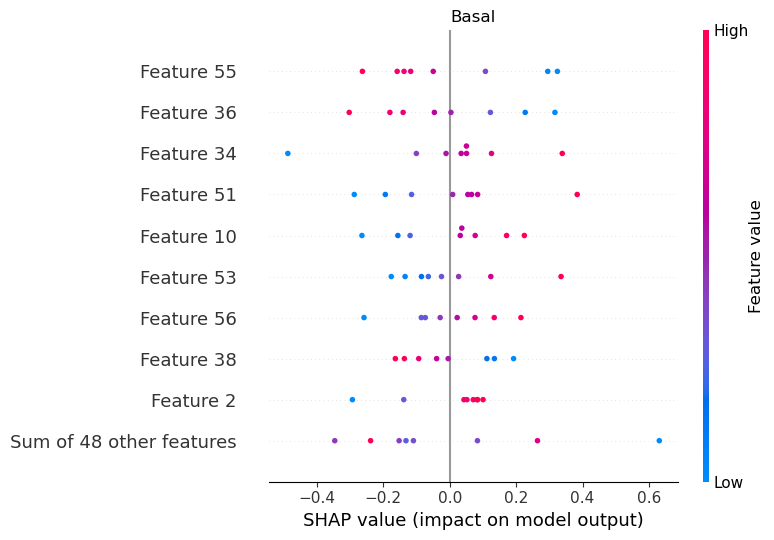

In [34]:
# 修士論文
model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca41",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "claudin-low",
}
rank_claudinlow_late = calc_score4late_recurrences(
    model_order_dict,
)


model_order_dict = {
    "model_name": ExtraSurvivalTrees().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca43",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "LumA",
}
rank_LumA_late = calc_score4late_recurrences(model_order_dict)


model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca77",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "LumB",
}
rank_LumB_late = calc_score4late_recurrences(model_order_dict)


model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca31",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Her2",
}
rank_Her2_late = calc_score4late_recurrences(model_order_dict)


model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca30",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Normal",
}
rank_Normal_late = calc_score4late_recurrences(model_order_dict)


model_order_dict = {
    "model_name": ComponentwiseGradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca58",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Basal",
}
rank_Basal_late = calc_score4late_recurrences(model_order_dict)

In [19]:
rank_claudinlow_late = rank_claudinlow_late.rename(
    columns={"gene name": "gene_claudin-low", "score": "score_claudin-low"}
)
rank_LumA_late = rank_LumA_late.rename(
    columns={"gene name": "gene_LumA", "score": "score_LumA"}
)
rank_LumB_late = rank_LumB_late.rename(
    columns={"gene name": "gene_LumB", "score": "score_LumB"}
)
rank_Her2_late = rank_Her2_late.rename(
    columns={"gene name": "gene_Her2", "score": "score_Her2"}
)
rank_Basal_late = rank_Basal_late.rename(
    columns={"gene name": "gene_Basal", "score": "Basal"}
)
rank_Normal_late = rank_Normal_late.rename(
    columns={"gene name": "gene_Normal", "score": "score_Normal"}
)

df_rank_late = rank_claudinlow_late.copy()
df_rank_late = pd.merge(df_rank_late, rank_LumA_late, right_index=True, left_index=True)
df_rank_late = pd.merge(df_rank_late, rank_LumB_late, right_index=True, left_index=True)
df_rank_late = pd.merge(df_rank_late, rank_Her2_late, right_index=True, left_index=True)
df_rank_late = pd.merge(
    df_rank_late, rank_Normal_late, right_index=True, left_index=True
)
df_rank_late = pd.merge(
    df_rank_late, rank_Basal_late, right_index=True, left_index=True
)
# 一時的な保存
df_rank_late.to_csv("./explain_score_late.csv")
df_rank_late

,gene_claudin-low,score_claudin-low,gene_LumA,score_LumA,gene_LumB,score_LumB,gene_Her2,score_Her2,gene_Normal,score_Normal,gene_Basal,Basal
0,FHOD1,0.956681,KIF11,2.092441,HOXB7,0.532904,PRKCB,0.834020,FERMT3,1.296209,TTYH3,0.302281
1,PAK7,0.951701,ECT2,2.061204,ZFYVE19,0.528605,CLK1,0.833607,ANKRA2,1.282055,C6orf105,0.286792
2,SON,0.946612,PTTG3,2.054869,TMEM132A,0.524554,IL23A,0.817898,CD53,1.277158,HIBADH,0.286336
3,EIF4A1,0.924516,HMGB2,2.014932,ATOX1,0.524482,ARHGAP15,0.813478,CCND2,1.264948,SULF2,0.284723
4,NRBF2,0.910935,HMMR,1.994203,TBCC,0.512003,ITK,0.808341,ITGAX,1.260690,INPP5A,0.282882
...,...,...,...,...,...,...,...,...,...,...,...,...
24363,GATA5,0.149008,AI015182,0.362954,CYP3A4,0.234109,SST,0.080691,AK093454,0.126536,AP3S1,0.096935
24364,LOC100130673,0.147709,C13orf26,0.357638,RPL21,0.232001,AA586561,0.074428,AA432158,0.116920,CF891400,0.096784
24365,AW299747,0.146727,LOC644662,0.355497,LHFPL1,0.230157,AW573137,0.073319,OR51B2,0.104508,SLC18A3,0.095853
24366,BQ028095,0.143598,LOC728724,0.345825,CCT7,0.229925,GAGE12B,0.072757,AW272084,0.099919,B3GAT3,0.094547


In [20]:
df_rank

,gene_claudin-low,score_claudin-low,gene_LumA,score_LumA,gene_LumB,score_LumB,gene_Her2,score_Her2,gene_Normal,score_Normal,gene_Basal,Basal
0,FAM98A,0.815218,KIF11,1.984594,CRYAB,0.398995,PRKCB,1.079602,ITGAX,1.600685,TTYH3,0.165710
1,WSB2,0.811024,ECT2,1.980717,ATOX1,0.394615,ITK,1.077976,FYN,1.582082,ANXA2P1,0.157219
2,YME1L1,0.805382,HMGB2,1.950213,MRAP,0.391781,IL23A,1.077428,FERMT3,1.577731,GCFC,0.155820
3,SON,0.804068,NEK2,1.943518,ZNF428,0.390918,PYHIN1,1.065910,ADA,1.563425,RPLP1,0.155291
4,SLC38A2,0.802511,PTTG3,1.942737,FHL1,0.390806,P2RY8,1.059498,APBB1IP,1.562869,FAM60A,0.155218
...,...,...,...,...,...,...,...,...,...,...,...,...
24363,BQ028095,0.097377,C13orf26,0.339557,BI770211,0.143752,SST,0.091662,AK093454,0.133731,SLC7A14,0.048426
24364,POU3F3,0.095030,LOC644662,0.337129,DA282036,0.143380,AA586561,0.090698,AB076958,0.131752,STON1,0.047252
24365,CSN2,0.094147,AI015182,0.332861,AW515292,0.142804,GAGE12B,0.075788,OR51B2,0.123224,B3GAT3,0.047103
24366,LOC100130673,0.092046,LOC728724,0.315551,TNKS2,0.142406,MYL10,0.069762,POU5F1B,0.093532,SLC18A3,0.047071


In [21]:
df_rank_late

,gene_claudin-low,score_claudin-low,gene_LumA,score_LumA,gene_LumB,score_LumB,gene_Her2,score_Her2,gene_Normal,score_Normal,gene_Basal,Basal
0,FHOD1,0.956681,KIF11,2.092441,HOXB7,0.532904,PRKCB,0.834020,FERMT3,1.296209,TTYH3,0.302281
1,PAK7,0.951701,ECT2,2.061204,ZFYVE19,0.528605,CLK1,0.833607,ANKRA2,1.282055,C6orf105,0.286792
2,SON,0.946612,PTTG3,2.054869,TMEM132A,0.524554,IL23A,0.817898,CD53,1.277158,HIBADH,0.286336
3,EIF4A1,0.924516,HMGB2,2.014932,ATOX1,0.524482,ARHGAP15,0.813478,CCND2,1.264948,SULF2,0.284723
4,NRBF2,0.910935,HMMR,1.994203,TBCC,0.512003,ITK,0.808341,ITGAX,1.260690,INPP5A,0.282882
...,...,...,...,...,...,...,...,...,...,...,...,...
24363,GATA5,0.149008,AI015182,0.362954,CYP3A4,0.234109,SST,0.080691,AK093454,0.126536,AP3S1,0.096935
24364,LOC100130673,0.147709,C13orf26,0.357638,RPL21,0.232001,AA586561,0.074428,AA432158,0.116920,CF891400,0.096784
24365,AW299747,0.146727,LOC644662,0.355497,LHFPL1,0.230157,AW573137,0.073319,OR51B2,0.104508,SLC18A3,0.095853
24366,BQ028095,0.143598,LOC728724,0.345825,CCT7,0.229925,GAGE12B,0.072757,AW272084,0.099919,B3GAT3,0.094547
